**EDA**<br/>
1. Удалены признаки `id`, `name`, `host_id`, `host_name`, `last_review`
2. Пропуски в признаке `reviews_per_month` заменены на средние значения
3. Согласно графикам распределения значения признаков крайне не нормированы, многj выбросов
4. Самый дорогой район - `Manhattan`
5. Наибольшая стандартная ошибка - в районе `Staten Island` у объектов размещения `Entire home/apt` и `Shared room`, а также у `Shared room` в `Bronx`
6. Коэффициенты корреляции очень малы, что говорит об отсутсвии линейной зависимости признаков
7. В связи с очень большим разбросом по цене имеет смысл разбить датасет по районам
8. Создан признак `dist_to_sightseeing`, представляющий собой евклидово расстояние объекта до достопримечательности, расположенной в каждом районе
9. Обработаны выбросы
10. Закодированы признаки `room_type`, `neighbourhood` и `neighbourhood_group`
11. Матрица корреляций показывает коэффициенты выше

**Модели**<br/>
1. Наименьшая средняя абсолютная ошибка и наибольший коэффициент детерминации - при применении `MaxAbsScaler`
2. При этом сами метрики линейных моделей `LinearRegression`, `RidgeCV`, `LassoCV`, `ElasticNetCV` очень плохие, по сути на результат повлияли только методы преобразования данных
3. Тюнинг `Ridge`  с помощью `GridSearchCV` - коэффициент детерминации стал выше **(0.175289)**
4. Самыми важными признаками оказались географические: `neighbourhood_by_price` (закодированный признак `neighbourhood`) и `latitude`, рейтинг признаков отличается от значения корреляции с целевой переменной - модель не очень "понимает", что от нее хотят
5. Удалены признаки `latitude`, `longitude`, `minimum_nights`, `reviews_per_month`, `calculated_host_listings_count`, которые почти не имеют взаимосвязи с целевой переменной (коэффициент меньше **0.05**).
6. Коэффициент детерминации стал ниже **(0.172245)**

# EDA

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial.distance import euclidean
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, ElasticNetCV

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(7)

**Loading dataset:**

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [3]:
data.shape

(48895, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

**Drop uninformative features:**

In [5]:
data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)

In [6]:
data.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
drop = data.dropna()
drop.shape[0] / data.shape[0]

0.7944166070150323

**Fill Nan:**

In [8]:
data['reviews_per_month'].fillna(data['reviews_per_month'].mean(), inplace=True)
data.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               48895 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [10]:
data.nunique()

neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
reviews_per_month                   938
calculated_host_listings_count       47
availability_365                    366
dtype: int64

## Distribution

In [11]:
groups_colors = ['#c47a39', '#5e89bd', '#80a35a', '#db6b9c', '#e8b851']
rooms_colors = ['#5ad6ca', '#e37dab', '#cfe37d']

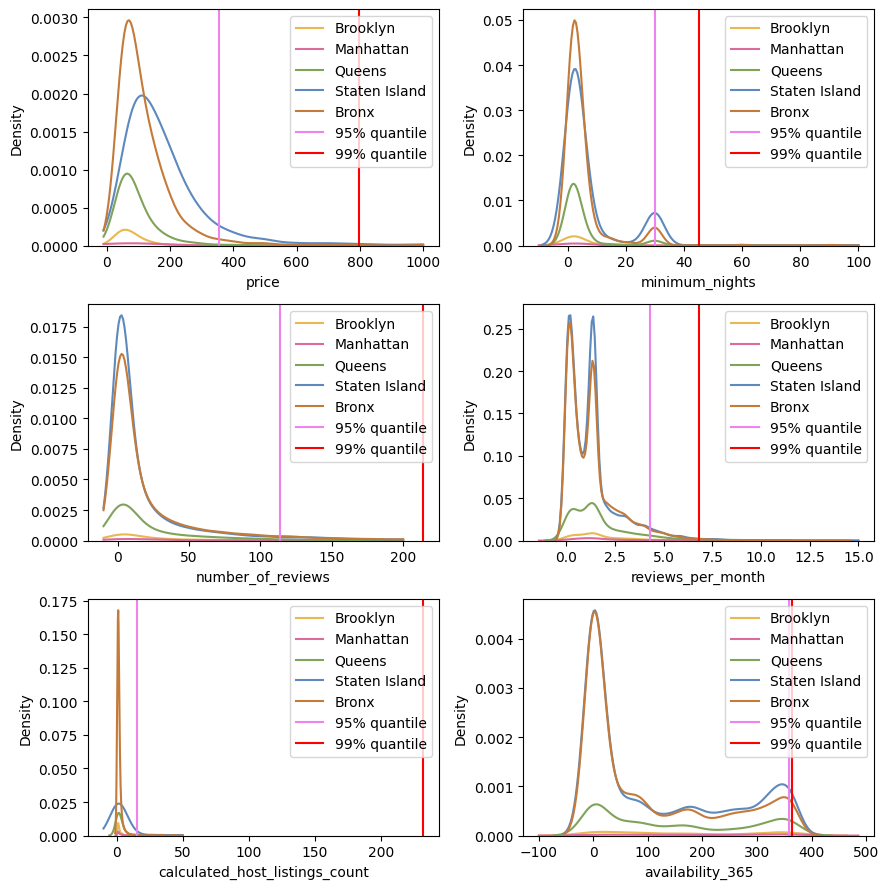

In [12]:
dis_legend = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx', '95% quantile', '99% quantile']

plt.figure(figsize=(9, 9))

plt.subplot(3, 2, 1)
sns.kdeplot(data=data, x='price', hue='neighbourhood_group',
            clip=(-10, 1000), palette=groups_colors)
plt.axvline(data['price'].quantile(0.95), label='95% quantile', c='violet')
plt.axvline(data['price'].quantile(0.99), label='99% quantile', c='red')
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 2)
sns.kdeplot(data=data, x='minimum_nights', hue='neighbourhood_group',
            clip=(-10, 100), palette=groups_colors)
plt.axvline(data['minimum_nights'].quantile(0.95), label='95% quantile', c='violet')
plt.axvline(data['minimum_nights'].quantile(0.99), label='99% quantile', c='red')
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 3)
sns.kdeplot(data=data, x='number_of_reviews', hue='neighbourhood_group',
            clip=(-10, 200), palette=groups_colors)
plt.axvline(data['number_of_reviews'].quantile(0.95), label='95% quantile', c='violet')
plt.axvline(data['number_of_reviews'].quantile(0.99), label='99% quantile', c='red')
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 4)
sns.kdeplot(data=data, x='reviews_per_month', hue='neighbourhood_group',
            clip=(-10, 15), palette=groups_colors)
plt.axvline(data['reviews_per_month'].quantile(0.95), label='95% quantile', c='violet')
plt.axvline(data['reviews_per_month'].quantile(0.99), label='99% quantile', c='red')
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 5)
sns.kdeplot(data=data, x='calculated_host_listings_count', hue='neighbourhood_group',
            clip=(-10, 50), palette=groups_colors)
plt.axvline(data['calculated_host_listings_count'].quantile(0.95), label='95% quantile', c='violet')
plt.axvline(data['calculated_host_listings_count'].quantile(0.99), label='99% quantile', c='red')
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 6)
sns.kdeplot(data=data, x='availability_365', hue='neighbourhood_group',
            clip=(-100, 500), palette=groups_colors)
plt.axvline(data['availability_365'].quantile(0.95), label='95% quantile', c='violet')
plt.axvline(data['availability_365'].quantile(0.99), label='99% quantile', c='red')
plt.legend(dis_legend, loc='upper right')

plt.tight_layout()
plt.show()

Data has lots of ouliers.

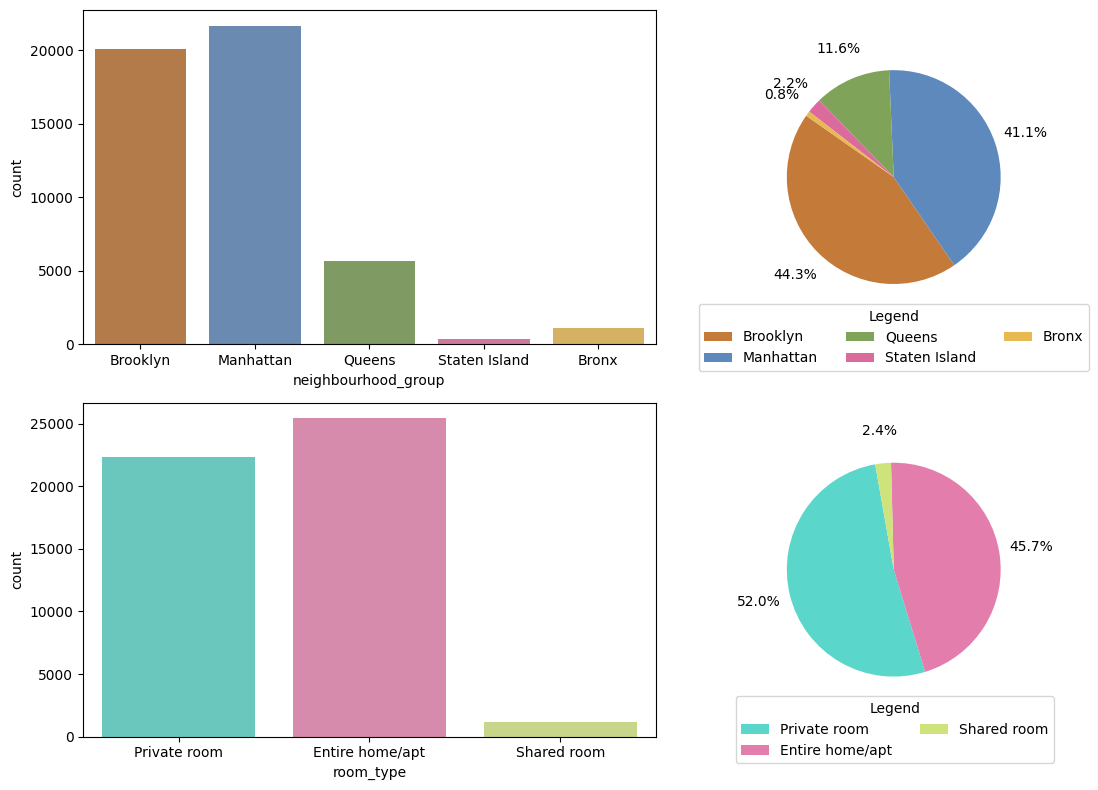

In [13]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=-0.2)

plt.subplot(2, 2, 1)
sns.countplot(data=data, x='neighbourhood_group', palette=groups_colors)
plt.subplot(2, 2, 2)
plt.pie(data['neighbourhood_group'].value_counts(),
        autopct='%1.1f%%',
        colors=groups_colors,
        pctdistance=1.3,
        radius=0.8,
        startangle=145)
plt.legend(title='Legend',
           loc='center',
           ncol=3,
           bbox_to_anchor=(0.5, 0.02),
           labels=data['neighbourhood_group'].unique())

plt.subplot(2, 2, 3)
sns.countplot(data=data, x='room_type', palette=rooms_colors)
plt.subplot(2, 2, 4)
plt.pie(data['room_type'].value_counts(),
        autopct='%1.1f%%',
        colors=rooms_colors,
        pctdistance=1.3,
        radius=0.8,
        startangle=100)
plt.legend(title='Legend',
           loc='lower right',
           ncol=2,
           bbox_to_anchor=(1.0, -0.1),
           labels=data['room_type'].unique())

plt.tight_layout()
plt.show()

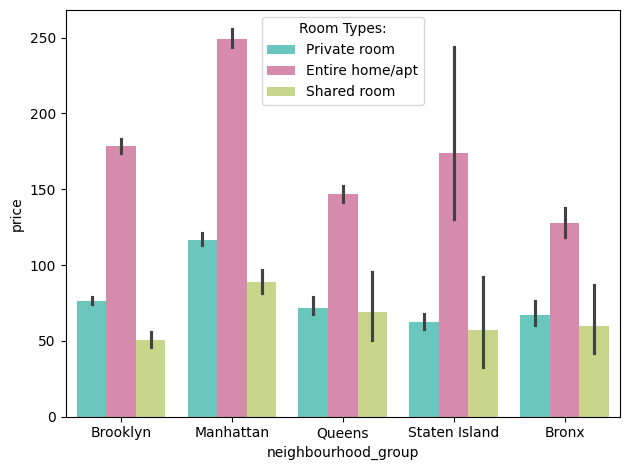

In [14]:
sns.barplot(data=data,
            x='neighbourhood_group',
            y='price',
            hue='room_type',
            palette=rooms_colors)

plt.legend(title='Room Types:')
plt.tight_layout()
plt.show()

Average prices by `neighbourhood_group`:

In [15]:
data.groupby('neighbourhood_group')['price'].mean().sort_values()

neighbourhood_group
Bronx             87.496792
Queens            99.517649
Staten Island    114.812332
Brooklyn         124.383207
Manhattan        196.875814
Name: price, dtype: float64

**Neighbourhood's coordinators: `latitude` & `longitude` data columns**

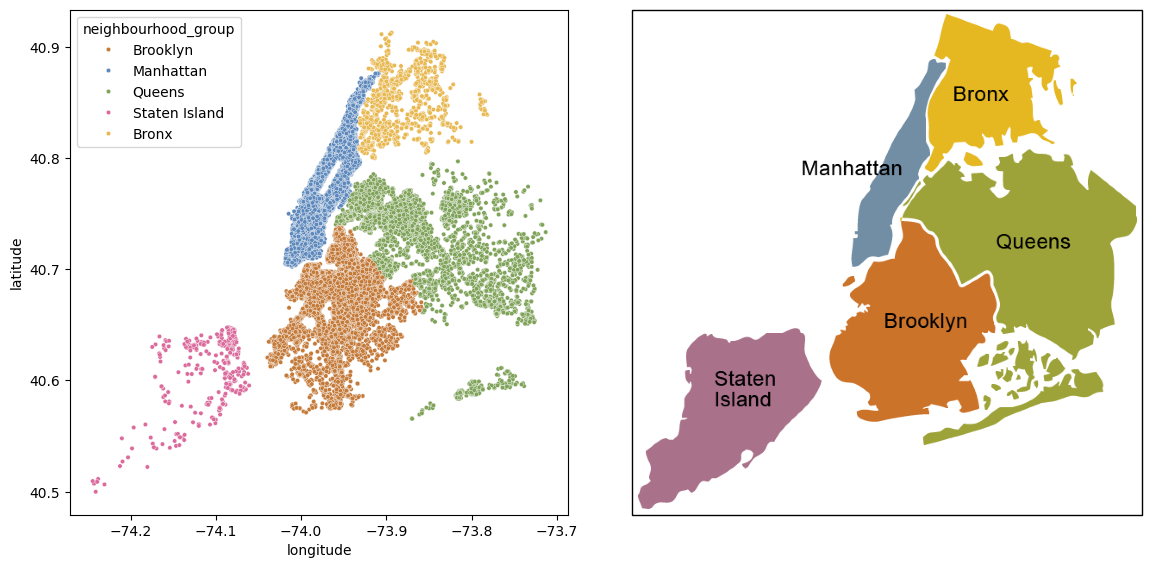

In [16]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=data,
                x='longitude',
                y='latitude',
                hue='neighbourhood_group',
                ax=ax_1,
                palette=groups_colors,
                s=10)

image_path = 'C:/Users/Anastasia Volkova/VScode/OTUS Jupyter/homework5/nyc.gif'
img = plt.imread(image_path)
img_box = OffsetImage(img, zoom=0.62)
ab = AnnotationBbox(img_box, (0.5, 0.5))
ax_2.add_artist(ab)
ax_2.axis('off')

plt.tight_layout()
plt.show()

## Correlation

In [17]:
corr = data[['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
             'availability_365', 'latitude', 'longitude', 'reviews_per_month']]
corr.corr()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,latitude,longitude,reviews_per_month
price,1.000000,0.042799,-0.047954,0.057472,0.081829,0.033939,-0.150019,-0.022373
minimum_nights,0.042799,1.000000,-0.080116,0.127960,0.144303,0.024869,-0.062747,-0.091942
number_of_reviews,-0.047954,-0.080116,1.000000,-0.072376,0.172028,-0.015389,0.059094,0.530093
calculated_host_listings_count,0.057472,0.127960,-0.072376,1.000000,0.225701,0.019517,-0.114713,-0.006701
availability_365,0.081829,0.144303,0.172028,0.225701,1.000000,-0.010983,0.082731,0.162980
latitude,0.033939,0.024869,-0.015389,0.019517,-0.010983,1.000000,0.084788,-0.009115
longitude,-0.150019,-0.062747,0.059094,-0.114713,0.082731,0.084788,1.000000,0.131599
reviews_per_month,-0.022373,-0.091942,0.530093,-0.006701,0.162980,-0.009115,0.131599,1.000000


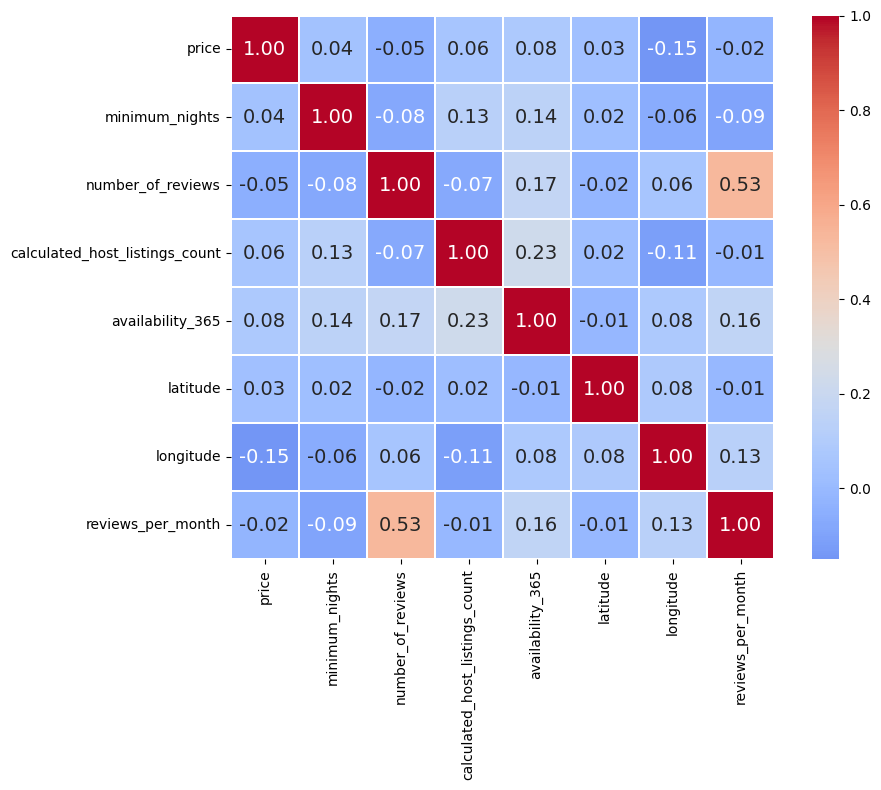

In [18]:
plt.figure(figsize=[10, 8])
sns.heatmap(corr.corr(),
            annot=True ,
            fmt = '.2f',
            annot_kws={"fontsize": 14},
            linewidths=0.25,
            center= 0.3,
            cmap= 'coolwarm',
            square=True)

plt.tight_layout()
plt.show()

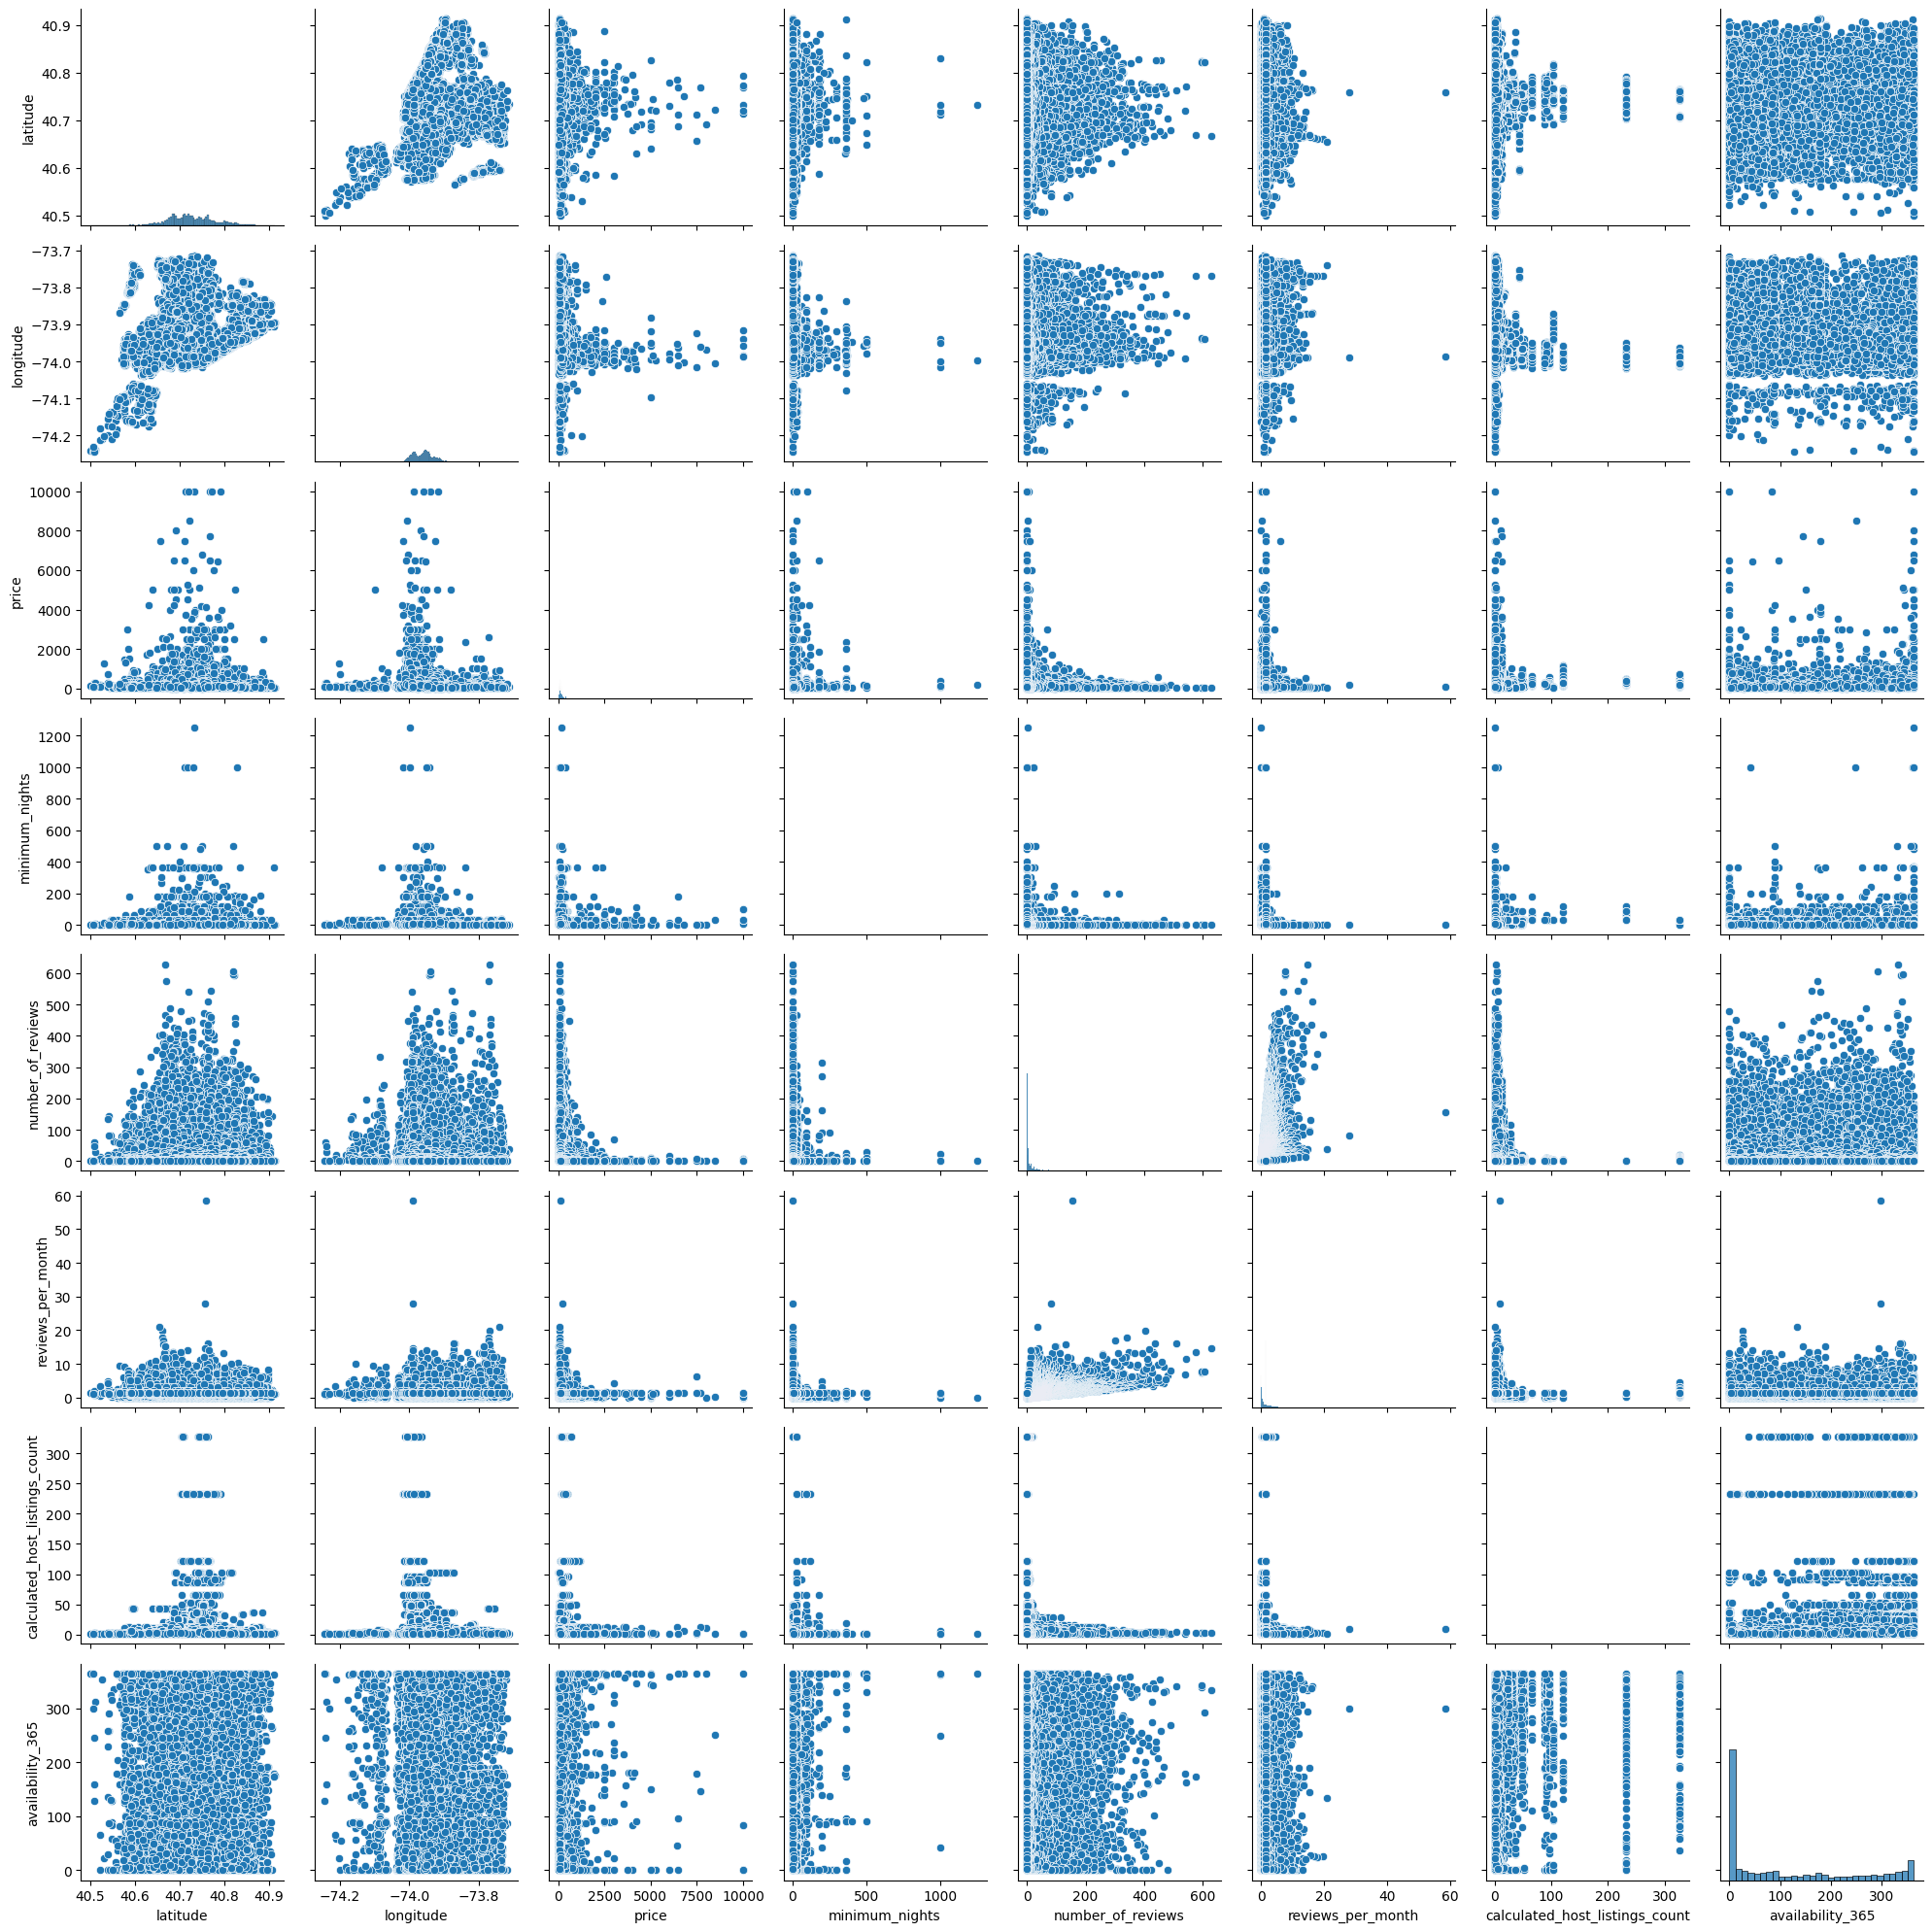

In [19]:
sns.pairplot(data)

plt.tight_layout()
plt.show()

## Divide data by area

In [20]:
data['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [21]:
brooklyn = data[data['neighbourhood_group'] == 'Brooklyn'].reset_index()
manhattan = data[data['neighbourhood_group'] == 'Manhattan'].reset_index()
queens = data[data['neighbourhood_group'] == 'Queens'].reset_index()
staten_island = data[data['neighbourhood_group'] == 'Staten Island'].reset_index()
bronx = data[data['neighbourhood_group'] == 'Bronx'].reset_index()

brooklyn.drop('index', axis=1, inplace=True)
manhattan.drop('index', axis=1, inplace=True)
queens.drop('index', axis=1, inplace=True)
staten_island.drop('index', axis=1, inplace=True)
bronx.drop('index', axis=1, inplace=True)
bronx.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Bronx,Highbridge,40.83232,-73.93184,Private room,40,1,219,2.040000,3,353
1,Bronx,Highbridge,40.83075,-73.93058,Private room,45,1,138,1.450000,3,323
2,Bronx,Clason Point,40.81309,-73.85514,Private room,90,2,0,1.373221,7,349
3,Bronx,Eastchester,40.88057,-73.83572,Entire home/apt,105,2,38,0.500000,13,365
4,Bronx,Kingsbridge,40.87207,-73.90193,Entire home/apt,90,30,4,0.350000,2,346


**How much does proximity to area sightseeing?**

In [22]:
empire_state_building = [40.748761, -73.985434]
brooklyn_heights_promenade = [40.696456, -73.997508]
corona_park = [40.740062, -73.840472]
botanical_garden = [40.642518, -74.103146]
bronx_zoo = [40.849957, -73.877317]

def distance(row):
    
    if row['neighbourhood_group'] == 'Manhattan':
        return euclidean((row['latitude'], row['longitude']),
                         (empire_state_building[0], empire_state_building[1]))
    
    if row['neighbourhood_group'] == 'Brooklyn':
        return euclidean((row['latitude'], row['longitude']),
                         (brooklyn_heights_promenade[0], brooklyn_heights_promenade[1]))
    
    if row['neighbourhood_group'] == 'Queens':
        return euclidean((row['latitude'], row['longitude']),
                         (corona_park[0], corona_park[1]))
    
    if row['neighbourhood_group'] == 'Staten Island':
        return euclidean((row['latitude'], row['longitude']),
                         (botanical_garden[0], botanical_garden[1]))
    
    if row['neighbourhood_group'] == 'Bronx':
        return euclidean((row['latitude'], row['longitude']),
                         (bronx_zoo[0], bronx_zoo[1]))

In [23]:
brooklyn['dist_to_sightseeing'] = brooklyn.apply(distance, axis=1)
manhattan['dist_to_sightseeing'] = manhattan.apply(distance, axis=1)
queens['dist_to_sightseeing'] = queens.apply(distance, axis=1)
staten_island['dist_to_sightseeing'] = staten_island.apply(distance, axis=1)
bronx['dist_to_sightseeing'] = bronx.apply(distance, axis=1)

**Drop ouliers:**

In [24]:
def outliers(dataset, columns):
    for column in columns:
        q = dataset[column].quantile(0.95)
        dataset = dataset[dataset[column] < q]
    return dataset

In [25]:
outliers(brooklyn, ['price', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month'])
outliers(manhattan, ['price', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month'])
outliers(queens, ['price', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month'])
outliers(staten_island, ['price', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month'])
outliers(bronx, ['price', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month'])

brooklyn = brooklyn.loc[brooklyn['minimum_nights'] < brooklyn['minimum_nights'].quantile(0.90)]
manhattan = manhattan.loc[manhattan['minimum_nights'] < manhattan['minimum_nights'].quantile(0.90)]
queens = queens.loc[queens['minimum_nights'] < queens['minimum_nights'].quantile(0.90)]
staten_island = staten_island.loc[staten_island['minimum_nights'] < staten_island['price'].quantile(0.90)]
bronx = bronx.loc[bronx['minimum_nights'] < bronx['minimum_nights'].quantile(0.90)]

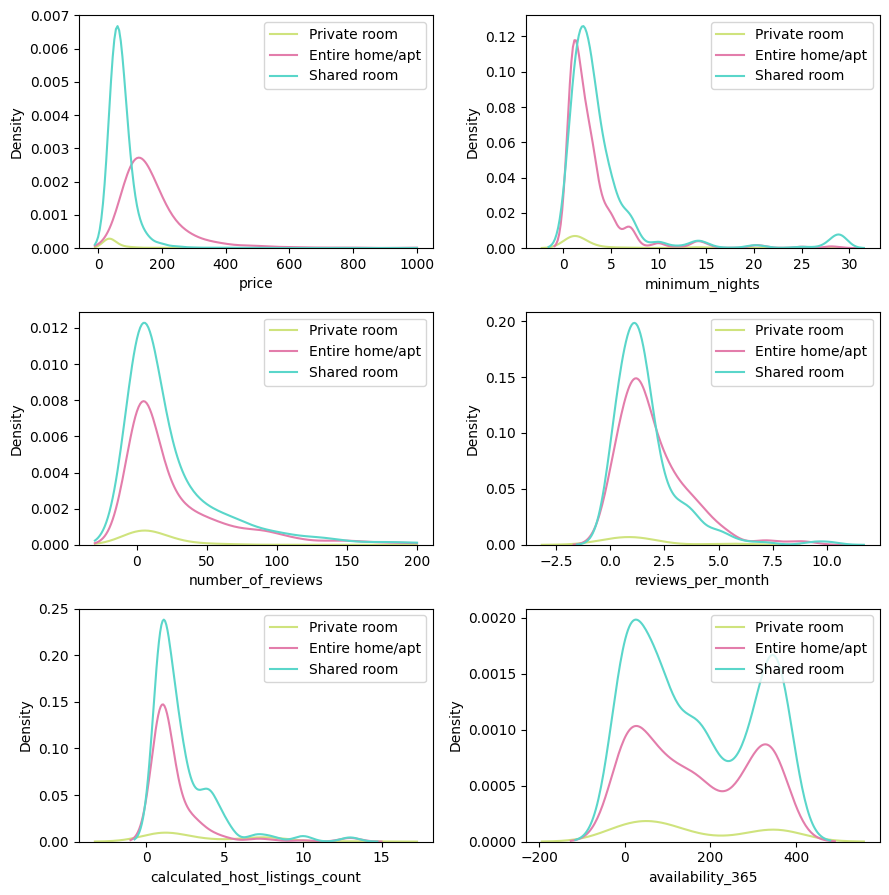

In [26]:
dis_legend = ['Private room', 'Entire home/apt', 'Shared room']

plt.figure(figsize=(9, 9))

plt.subplot(3, 2, 1)
sns.kdeplot(data=brooklyn, x='price', hue='room_type',
            clip=(-10, 1000), palette=rooms_colors)
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 2)
sns.kdeplot(data=manhattan, x='minimum_nights', hue='room_type',
            clip=(-10, 100), palette=rooms_colors)
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 3)
sns.kdeplot(data=queens, x='number_of_reviews', hue='room_type',
            clip=(-30, 200), palette=rooms_colors)
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 4)
sns.kdeplot(data=staten_island, x='reviews_per_month', hue='room_type',
            clip=(-10, 15), palette=rooms_colors)
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 5)
sns.kdeplot(data=bronx, x='calculated_host_listings_count', hue='room_type',
            clip=(-10, 50), palette=rooms_colors)
plt.legend(dis_legend, loc='upper right')

plt.subplot(3, 2, 6)
sns.kdeplot(data=bronx, x='availability_365', hue='room_type',
            palette=rooms_colors)
plt.legend(dis_legend, loc='upper right')

plt.tight_layout()
plt.show()

## Encoding

OneHotEncoder for `room_type`:

In [27]:
ohe = OneHotEncoder(use_cat_names=True)

brooklyn = brooklyn.drop(['room_type'], axis = 1).join(ohe.fit_transform(brooklyn[['room_type']], axis = 0))
manhattan = manhattan.drop(['room_type'], axis = 1).join(ohe.fit_transform(manhattan[['room_type']], axis = 0))
queens = queens.drop(['room_type'], axis = 1).join(ohe.fit_transform(queens[['room_type']], axis = 0))
staten_island = staten_island.drop(['room_type'], axis = 1).join(ohe.fit_transform(staten_island[['room_type']], axis = 0))
bronx = bronx.drop(['room_type'], axis = 1).join(ohe.fit_transform(bronx[['room_type']], axis = 0))

Encodind `neighbourhoods` by average prices:

In [28]:
def encode_nh(dataset):
    dataset['neighbourhood_by_price'] = dataset['neighbourhood'].map(dataset.groupby('neighbourhood')['price'].mean())
    dataset = dataset.drop(['neighbourhood'], axis=1)
    # dataset = dataset.drop(['neighbourhood_group'], axis=1)
    return dataset

Encodind `neighbourhoods_group` by average prices:

In [29]:
def encode_nhg(dataset):
    nhg_map = {'Bronx': 1,
               'Queens': 2,
               'Staten Island': 3,
               'Brooklyn': 4,
               'Manhattan': 5}
    
    dataset['neighbourhood_group'] = dataset['neighbourhood_group'].map(nhg_map)
    
    return dataset

In [30]:
brooklyn = encode_nh(brooklyn)
brooklyn = encode_nhg(brooklyn)

manhattan = encode_nh(manhattan)
manhattan = encode_nhg(manhattan)

queens = encode_nh(queens)
queens = encode_nhg(queens)

staten_island = encode_nh(staten_island)
staten_island = encode_nhg(staten_island)

bronx = encode_nh(bronx)
bronx = encode_nhg(bronx)

## Correlation

For `neighbourhood_group`:

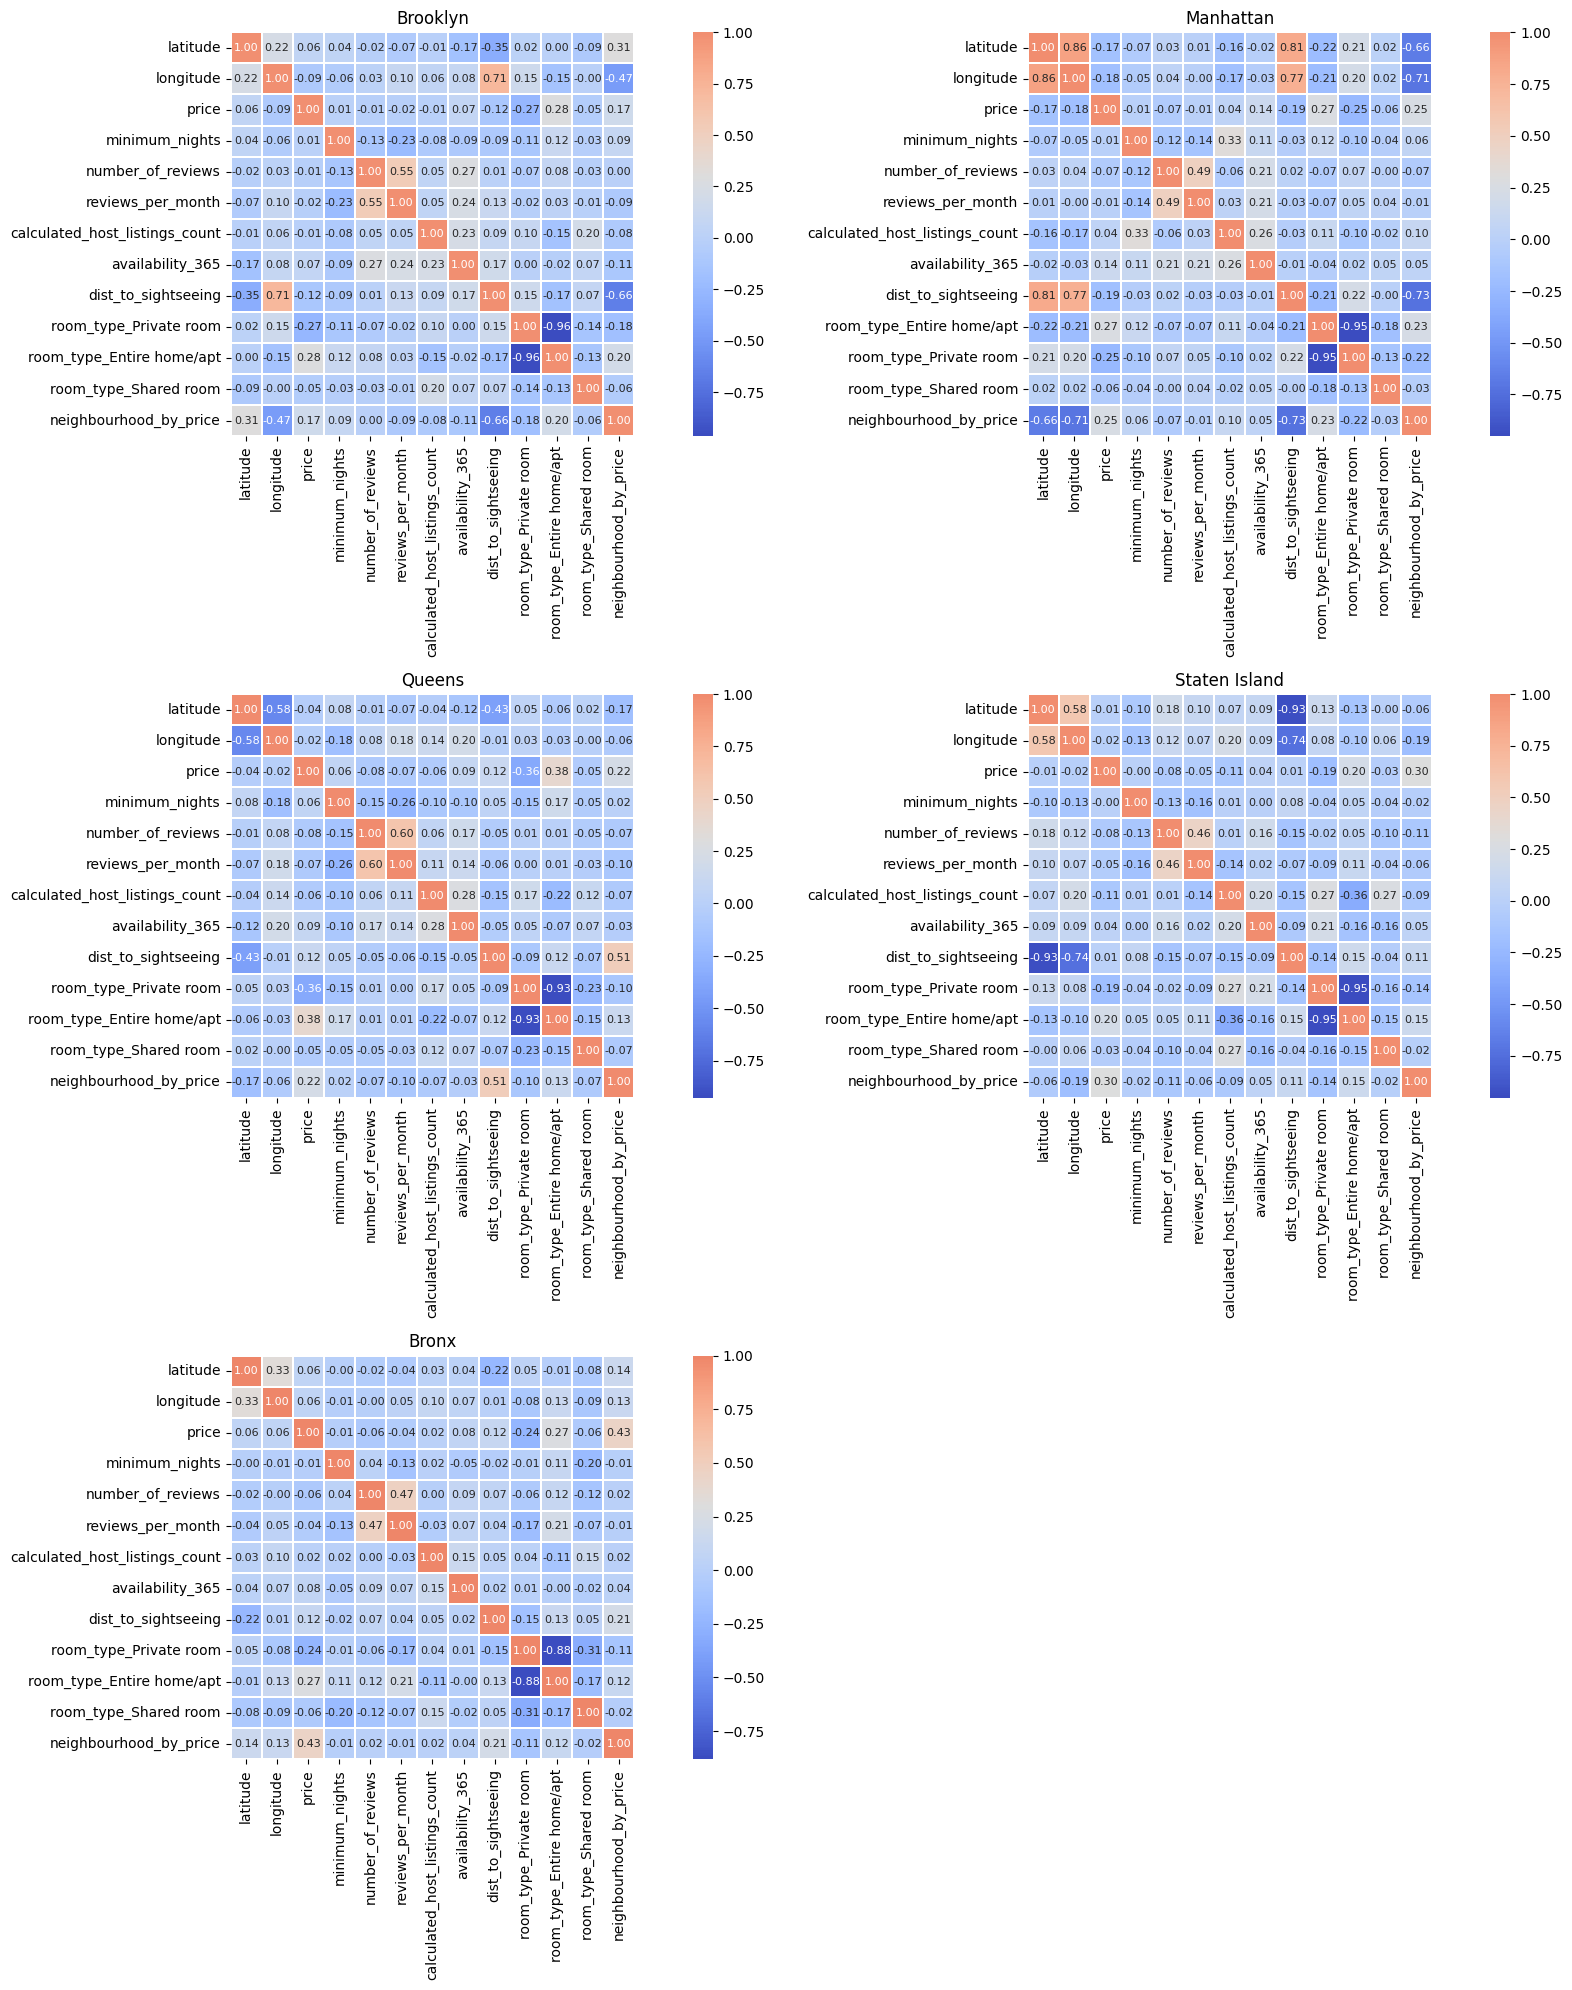

In [31]:
neighbourhoods = [brooklyn.loc[:, brooklyn.columns !='neighbourhood_group'],
                  manhattan.loc[:, manhattan.columns !='neighbourhood_group'],
                  queens.loc[:, queens.columns !='neighbourhood_group'],
                  staten_island.loc[:, staten_island.columns !='neighbourhood_group'],
                  bronx.loc[:, bronx.columns !='neighbourhood_group']]
labels = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

plt.figure(figsize=[20, 20])

for i, neighbourhood in enumerate(neighbourhoods):

    plt.subplot(3, 2, i+1).set_title(neighbourhood)

    sns.heatmap(neighbourhood.corr(),
                annot=True ,
                fmt = '.2f',
                annot_kws={"fontsize": 8},
                linewidths=0.25,
                center= 0.3,
                cmap= 'coolwarm',
                square=True).set_title(labels[i])
    plt.subplots_adjust(wspace=-1.5)

plt.tight_layout()
plt.show()

For all dataset:

In [32]:
df = pd.concat([brooklyn, manhattan, queens, staten_island, bronx], axis=0)

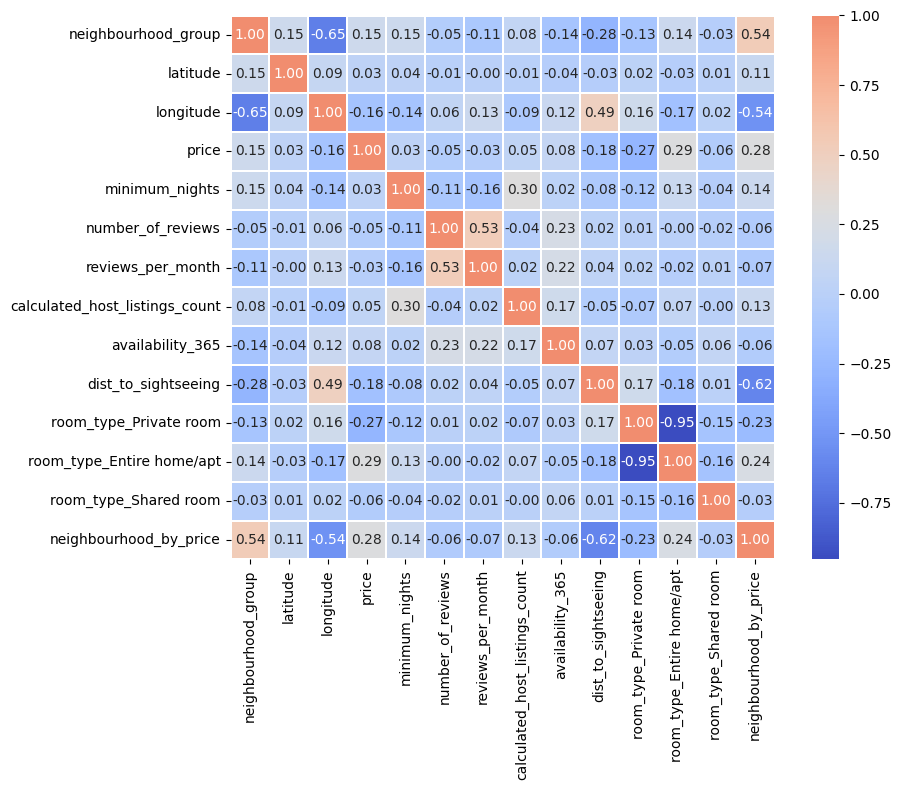

In [33]:
plt.figure(figsize=[10, 8])
sns.heatmap(df.corr(),
            annot=True ,
            fmt = '.2f',
            annot_kws={"fontsize": 10},
            linewidths=0.25,
            center= 0.3,
            cmap= 'coolwarm',
            square=True)

plt.tight_layout()
plt.show()

## Models

In [34]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30301, 13), (12987, 13), (30301,), (12987,))

In [35]:
def model(method, scaler, X_train, X_test, y_train, y_test, cv=None, random_state=42):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = method
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    train_RMSE = round(np.sqrt(sm.mean_squared_error(y_train, y_train_pred)), 4)
    test_RMSE = round(np.sqrt(sm.mean_squared_error(y_test, y_pred)), 4)
    mae = round(sm.mean_absolute_error(y_test, y_pred), 4)
    r2 = round(sm.r2_score(y_test, y_pred), 6)
    mape = sm.mean_absolute_percentage_error(y_test, y_pred).round(2)
    return train_RMSE, test_RMSE, mae, r2, mape

In [36]:
def report(model, name):
    report = pd.DataFrame({'Train RMSE': model[0],
                           'Test RMSE': model[1],
                           'MAE': model[2],
                           'R2': model[3],
                           'MAPE': model[4]},
                           index=[name])
    report['MAPE'] = report['MAPE'].apply(lambda x: f'{x:.2f}')
    return report

**LinearRegression**

In [37]:
lr_std = model(LinearRegression(), StandardScaler(), X_train, X_test, y_train, y_test)
report(lr_std, 'Linear Regression with Standard Scaler')

,Train RMSE,Test RMSE,MAE,R2,MAPE
Linear Regression with Standard Scaler,179.1768,227.3986,69.3307,0.115464,146233603757621.66


In [38]:
lr_mms = model(LinearRegression(), MinMaxScaler(), X_train, X_test, y_train, y_test)
report(lr_mms, 'Linear Regression with Min Max Scaler')

,Train RMSE,Test RMSE,MAE,R2,MAPE
Linear Regression with Min Max Scaler,179.1752,227.4005,69.3477,0.115449,146643542960214.41


In [39]:
lr_rs = model(LinearRegression(), RobustScaler(), X_train, X_test, y_train, y_test)
report(lr_mms, 'Linear Regression with Robust Scaler')

,Train RMSE,Test RMSE,MAE,R2,MAPE
Linear Regression with Robust Scaler,179.1752,227.4005,69.3477,0.115449,146643542960214.41


In [40]:
lr_mas = model(LinearRegression(), MaxAbsScaler(), X_train, X_test, y_train, y_test)
report(lr_mms, 'Linear Regression with Max Abs Scaler')

,Train RMSE,Test RMSE,MAE,R2,MAPE
Linear Regression with Max Abs Scaler,179.1752,227.4005,69.3477,0.115449,146643542960214.41


`MaxAbsScaler` - best R2 & MAPE

**RidgeCV, LassoCV и ElasticNetCV**

In [41]:
ridge_cv = model(RidgeCV(), MaxAbsScaler(), X_train, X_test, y_train, y_test, cv=5)

In [42]:
lasso_cv = model(LassoCV(), MaxAbsScaler(), X_train, X_test, y_train, y_test, cv=5)

In [43]:
elastic_cv = model(ElasticNetCV(), MaxAbsScaler(), X_train, X_test, y_train, y_test, cv=5)

Default params `RidgeCV` with `MaxAbsScaler` - best R2 & MAPE

## Tuning

In [44]:
scaler = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
y_train_pred = ridge.predict(X_train)

In [45]:
parameters = {'alpha': [0, 0.1, 1, 10, 100, 1000],
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
              'random_state': [42]}

gs_ridge = GridSearchCV(estimator=ridge,
                        param_grid=parameters,
                        scoring='r2',
                        cv=5,
                        n_jobs= -1)


gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [True, False], 'random_state': [42],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='r2')

In [46]:
gs_ridge.best_params_

{'alpha': 0, 'fit_intercept': True, 'random_state': 42, 'solver': 'auto'}

In [47]:
gs_ridge.best_score_

0.17528949458711435

In [48]:
ridge.intercept_

-132.24426146326024

**Feature Importance**

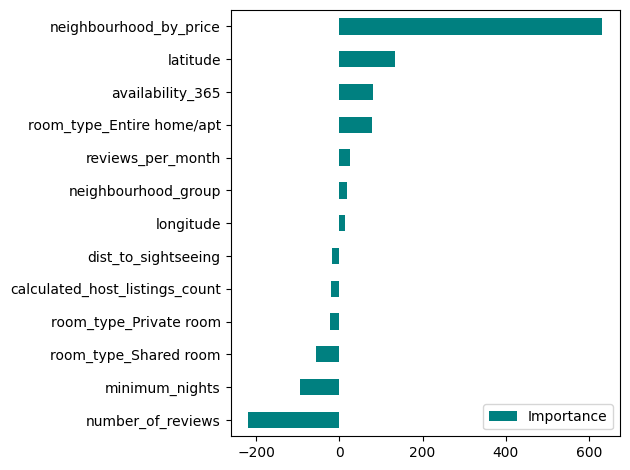

In [49]:
feature = df.drop(['price'], axis=1).columns
importance = ridge.coef_
f_i = pd.DataFrame(index=feature,
                   data={'Importance': importance})
f_i.sort_values(['Importance'], inplace=True)

f_i.plot.barh(color=['teal'])

plt.tight_layout()
plt.show()

Drop `latitude`, `longitude`, `minimum_nights`, `reviews_per_month`, `calculated_host_listings_count` features. Correlation coef less **0.05**.

In [52]:
df_copy = df.copy()
df_copy.drop(['latitude', 'longitude', 'minimum_nights', 'reviews_per_month', 'calculated_host_listings_count'], axis=1, inplace=True)

In [53]:
X = df_copy.drop(['price'], axis=1)
y = df_copy['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30301, 8), (12987, 8), (30301,), (12987,))

In [54]:
scaler = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
y_train_pred = ridge.predict(X_train)

In [55]:
parameters = {'alpha': [0, 0.1, 1, 10, 100, 1000],
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
              'random_state': [42]}

gs_ridge = GridSearchCV(estimator=ridge,
                        param_grid=parameters,
                        scoring='r2',
                        cv=5,
                        n_jobs= -1)


gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [True, False], 'random_state': [42],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='r2')

In [56]:
gs_ridge.best_params_

{'alpha': 0, 'fit_intercept': True, 'random_state': 42, 'solver': 'auto'}

In [57]:
gs_ridge.best_score_

0.1722452411519067

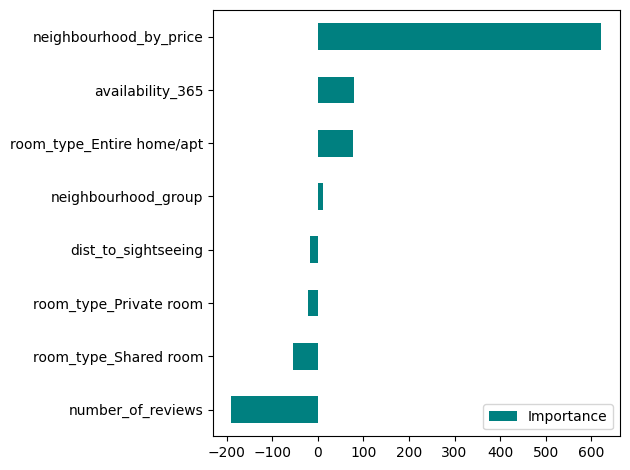

In [58]:
feature = df_copy.drop(['price'], axis=1).columns
importance = ridge.coef_
f_i = pd.DataFrame(index=feature,
                   data={'Importance': importance})
f_i.sort_values(['Importance'], inplace=True)

f_i.plot.barh(color=['teal'])

plt.tight_layout()
plt.show()

:-(